In [1]:
#@title Подключение библиотек
# Подключение нужных слоев из модуля tensorflow.keras.layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Матрица ошибок классификатора
from PIL import Image # Отрисовка изображений
from sklearn.model_selection import train_test_split # Разделение на обучающую и проверочную/тестовую выборку

import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Отрисовка графиков
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

import os # Для работы с файлами
import random # Генерация случайных чисел
import gdown # Подключение модуля для загрузки данных из облака
import gc

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

class Worker:
  def __init__(self):
    self.IMAGE_PATH = '/content/data/'
    self.CLASS_LIST = None
    self.CLASS_COUNT = None

  def load_dataset(self):
    arch_name = gdown.download('https://storage.yandexcloud.net/aiueducation/marketing/23.03/construction.zip', None, quiet=True)
    # Разархивация датасета в директорию '/content'
    !unzip -qo {arch_name} -d /content/data
    self.CLASS_LIST = sorted(os.listdir(self.IMAGE_PATH))
    self.CLASS_COUNT = len(self.CLASS_LIST)
    print(f'Датасет загружен!\n')
    print(f'Количество классов: {self.CLASS_COUNT}')
    res = "\n  * ".join(self.CLASS_LIST)
    print(f'Метки классов:\n  * {res}')

  def show_samples(self, count = 3):
    n_rows = count
    # Создание заготовки для изображений всех классов
    fig, axs = plt.subplots(n_rows, self.CLASS_COUNT, figsize=(35, 5*n_rows-5))

    # Для всех номеров классов:
    for i in range(self.CLASS_COUNT):
      for j in range(n_rows):
        # Формирование пути к папке содержимого класса
        car_path = f'{self.IMAGE_PATH}{self.CLASS_LIST[i]}/'
        # Выбор случайного фото из i-го класса
        img_path = car_path + random.choice(os.listdir(car_path))
        # Отображение фотографии (подробнее будет объяснено далее)
        axs[j][i].set_title(self.CLASS_LIST[i])
        axs[j][i].imshow(Image.open(img_path))
        axs[j][i].axis('off')
    # Отрисовка всего полотна
    plt.show()

  def dataset_info(self):
    self.data_files = []                           # Cписок путей к файлам картинок
    self.data_labels = []                          # Список меток классов, соответствующих файлам
    cnt_files = []                            # Количество файлов каждого класса

    for class_label in range(self.CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
        class_name = self.CLASS_LIST[class_label]  # Выборка имени класса из списка имен
        class_path = self.IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
        class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
        cnt_files.append(len(class_files))
        print(f'Размер класса {class_name} составляет {len(class_files)}')
        # Добавление к общему списку всех файлов класса с добавлением родительского пути
        self.data_files += [f'{class_path}/{file_name}' for file_name in class_files]

        # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
        self.data_labels += [class_label] * len(class_files)

    print('\nОбщий размер базы для обучения:', len(self.data_labels))
    plt.figure(figsize=(25, 8))
    plt.bar(self.CLASS_LIST, cnt_files)
    plt.show()

  def create_sets(self, size=(64, 64)):
    IMG_WIDTH = size[0]                             # Ширина изображения
    IMG_HEIGHT = size[1]                           # Высота изображения
    data_images = []                               # Пустой список для данных изображений

    for file_name in self.data_files:
        # Открытие и смена размера изображения
        img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT))

        # Конвертация изображений в режиме CMYK в режим RGB
        if img.mode == 'CMYK':
          img = img.convert('RGB')

        img_np = np.array(img)                # Перевод в numpy-массив
        data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку


    x_data = np.array(data_images)            # Перевод общего списка изображений в numpy-массив
    y_data = np.array(self.data_labels)            # Перевод общего списка меток класса в numpy-массив

    # Нормированние массива изображений
    x_data = x_data / 255.
    x_train, x_test, y_train, y_test = train_test_split(x_data, # набор параметров
                                                    y_data, # набор меток классов
                                                    test_size=0.2, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость
    print(f'Размер обучающей выборки: {x_train.shape}')
    print(f'Размер проверочной выборки: {x_test.shape}')
    self.sets = (x_train, x_test, y_train, y_test)
    gc.collect()
    return x_train, x_test, y_train, y_test

  def ShowConfusionMatrix(self, model, x_test, y_test):
    cm = confusion_matrix(y_test,
                          np.argmax(model.predict(x_test, verbose=0), axis=1),
                          normalize = 'true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.CLASS_LIST)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.grid(False)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

  def show_learning_information(self, history, model):
    print('График обучения:')
    # Создание полотна для рисунка
    plt.figure(1, figsize=(10, 6))

    # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
    plt.plot(history.history['accuracy'],
            label='Доля верных ответов на обучающем наборе')
    plt.plot(history.history['val_accuracy'],
            label='Доля верных ответов на проверочном наборе')
    # Задание подписей осей
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()
    # Фиксация графиков и рисование всей картинки
    plt.show()
    print(f'Максимальная точность на обучающей выборке: {round(np.array(history.history["accuracy"]).max(), 3)}')
    print(f'Максимальная точность на проверочной выборке: {round(np.array(history.history["val_accuracy"]).max(), 3)}')

    print('\nМатрица ошибок для обучающей выборки:')
    self.ShowConfusionMatrix(model, self.sets[0], self.sets[2])
    print('\nМатрица ошибок для проверочной выборки:')
    self.ShowConfusionMatrix(model, self.sets[1], self.sets[3])

  def train_model(self, funcModel, count):
    # Обучение модели сверточной нейронной сети подготовленных данных
    cnt = count
    history_accuracy = []
    history_val_accuracy = []
    for i in range(cnt):
      model = funcModel()
      store_learning = model.fit(x_train,
                                y_train,
                                validation_data=(x_test, y_test),
                                shuffle=True,
                                batch_size=25,
                                epochs=50,
                                verbose=0)
      history_accuracy.append(store_learning.history['accuracy'])
      history_val_accuracy.append(store_learning.history['val_accuracy'])
      print(f'{bcolors.BOLD}{bcolors.OKBLUE}Обучение №{i+1} завершено. Результаты{bcolors.ENDC}')
      print(f'Максимальная точность на обучающей выборке: {round(np.array(store_learning.history["accuracy"]).max(), 3)}')
      print(f'Максимальная точность на проверочной выборке: {round(np.array(store_learning.history["val_accuracy"]).max(), 3)}')
      print('\n'*3)
    print(f'{bcolors.BOLD}###############################################################################{bcolors.ENDC}')
    print(f'{bcolors.HEADER} Финальные результаты{bcolors.ENDC}')
    print(f'Средняя точность на обучающей выборке: {round(np.array(history_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на обучающей выборке: {round(np.array(history_accuracy).max(), 3)}')
    print(f'Средняя точность на проверочной выборке: {round(np.array(history_val_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на проверочной выборке: {round(np.array(history_val_accuracy).max(), 3)}')

worker=Worker()

In [2]:
# Загрузка датасета
worker.load_dataset()

Датасет загружен!

Количество классов: 8
Метки классов:
  * bulldozer
  * car
  * dump_truck
  * excavator
  * ice_rink
  * mining_loader
  * person
  * truck_crane


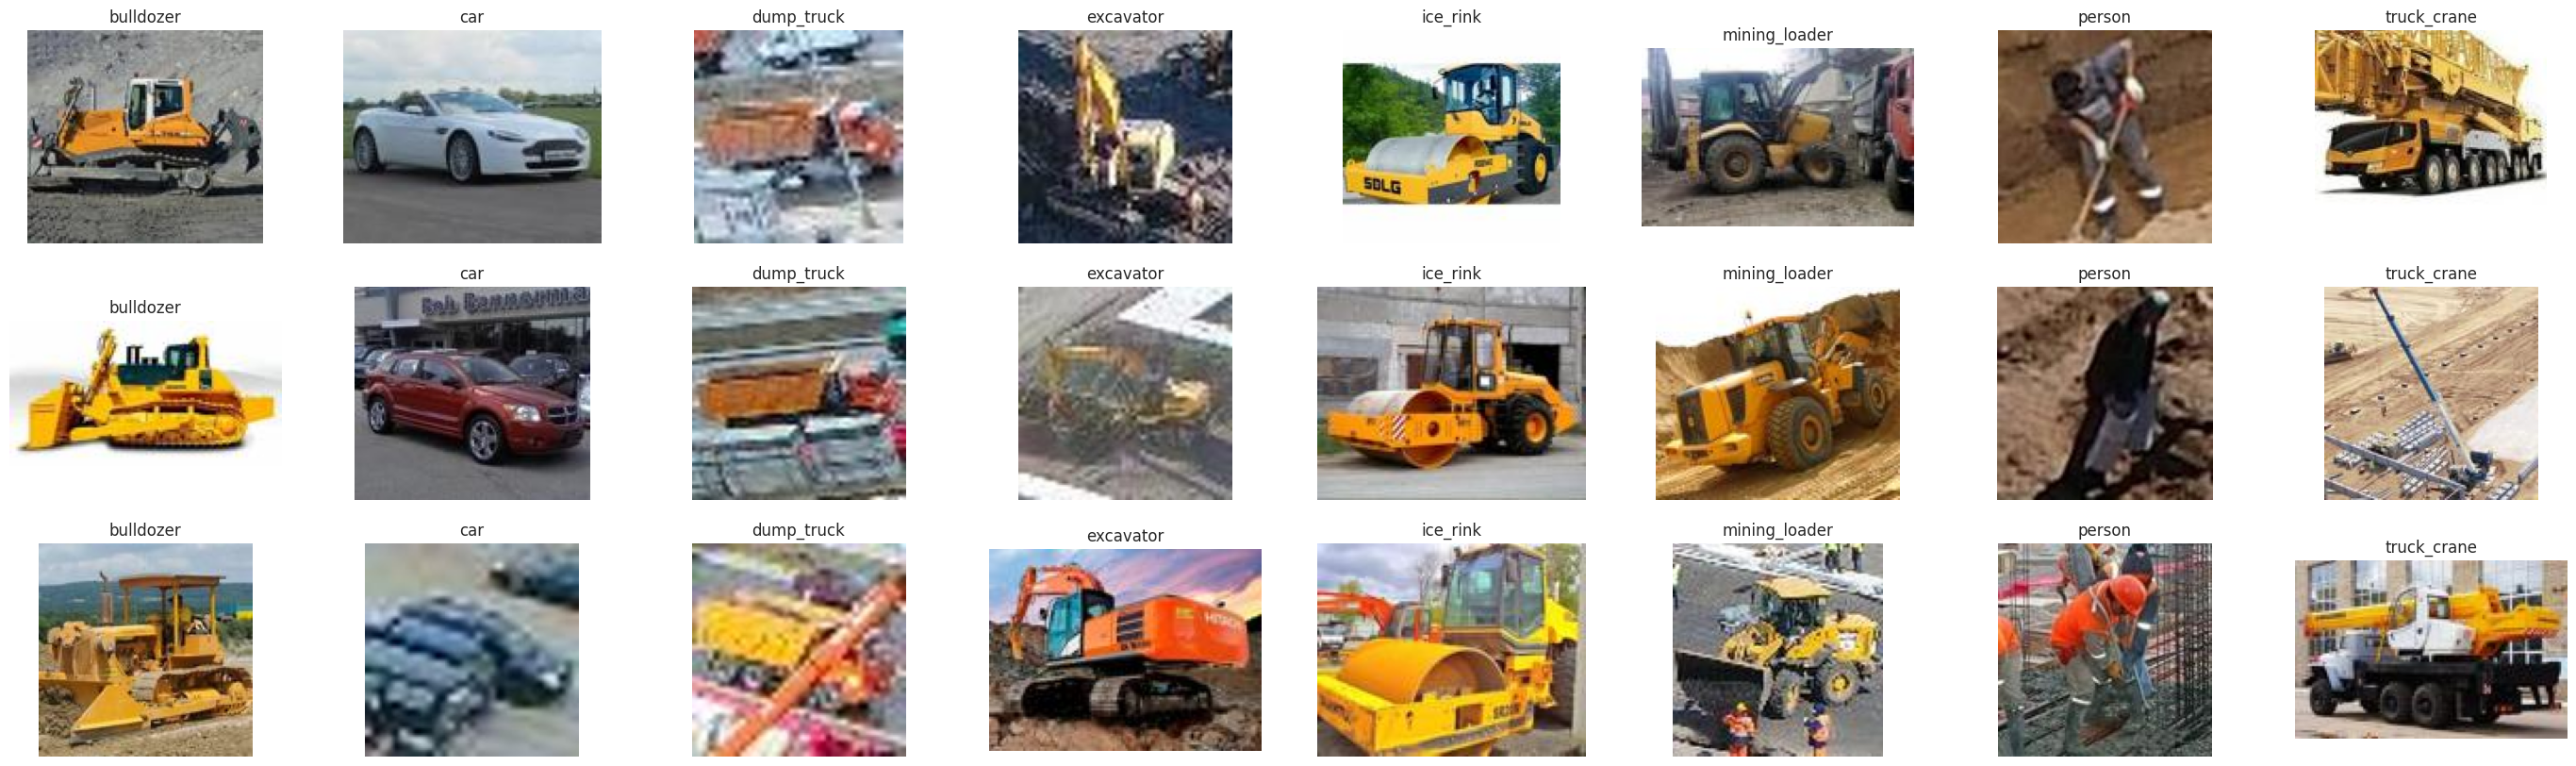

In [3]:
# Выводи примеров
worker.show_samples()

Размер класса bulldozer составляет 194
Размер класса car составляет 1586
Размер класса dump_truck составляет 797
Размер класса excavator составляет 316
Размер класса ice_rink составляет 293
Размер класса mining_loader составляет 514
Размер класса person составляет 969
Размер класса truck_crane составляет 321

Общий размер базы для обучения: 4990


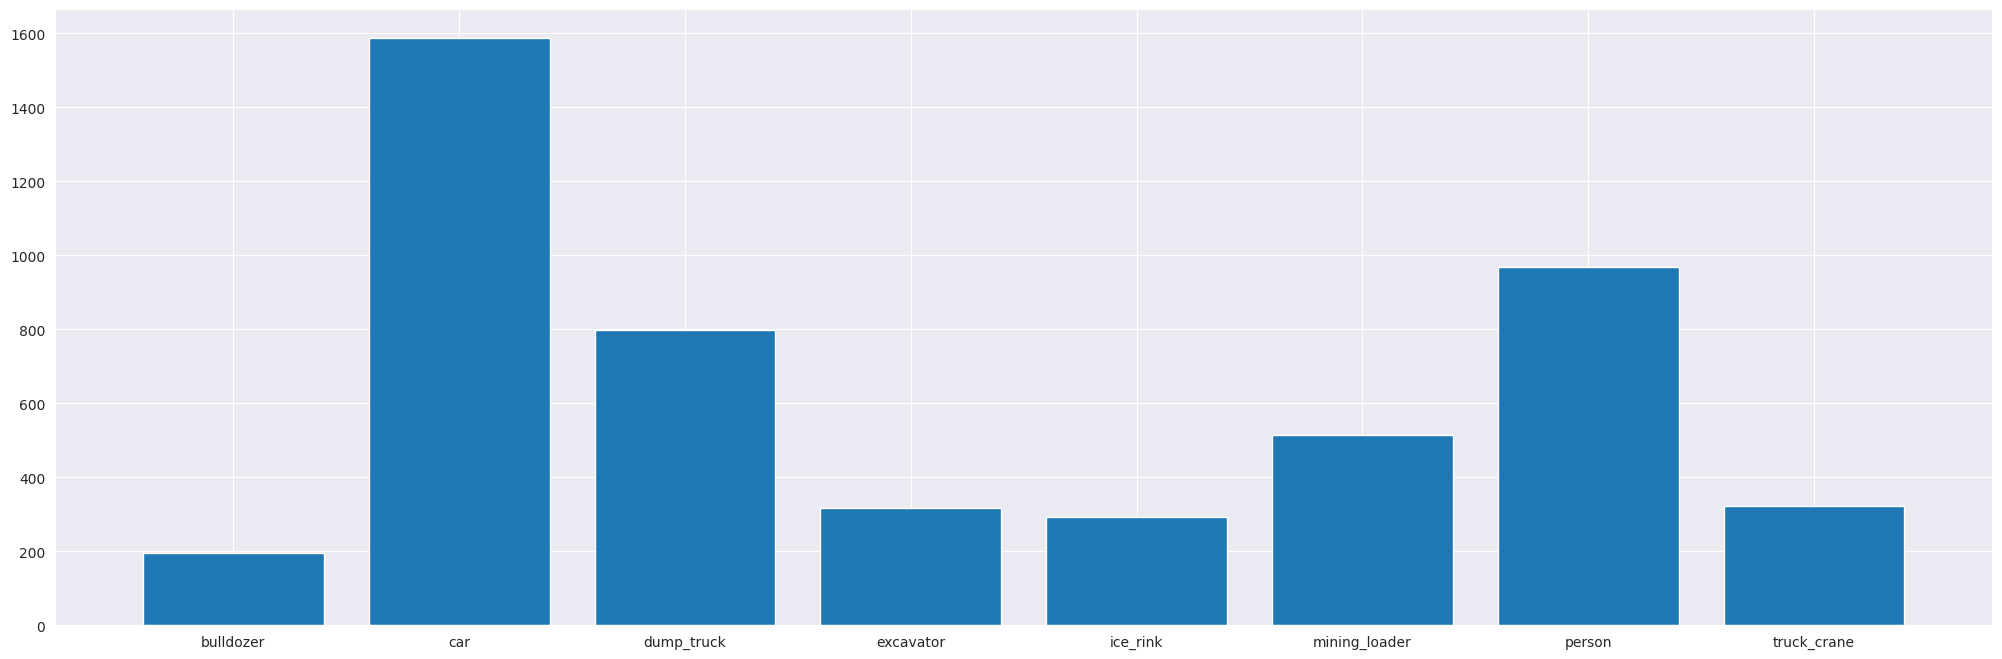

In [4]:
# Информация о датасете
worker.dataset_info()

<h1><b> Эксперименты </b></h1>

### Эксп. №1 (82.7%)

In [5]:
# Создание выборок
img_size=(64, 64)
x_train, x_test, y_train, y_test = worker.create_sets(img_size)

Размер обучающей выборки: (3992, 64, 64, 3)
Размер проверочной выборки: (998, 64, 64, 3)


In [6]:
def create_model():
  # Создание модели последовательной архитектуры
  model = Sequential()

  # Первый сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_size[0], img_size[1], 3)))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  # Второй сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  # Блок классификации
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  # Компиляция модели
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
  return model

model = create_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=50,
                           verbose=1)

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.4026 - loss: 1.7204 - val_accuracy: 0.6413 - val_loss: 1.1673
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6775 - loss: 0.9831 - val_accuracy: 0.7415 - val_loss: 0.8471
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7483 - loss: 0.7849 - val_accuracy: 0.7796 - val_loss: 0.6986
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7918 - loss: 0.6626 - val_accuracy: 0.7836 - val_loss: 0.6772
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8000 - loss: 0.5878 - val_accuracy: 0.8056 - val_loss: 0.6190
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8494 - loss: 0.4721 - val_accuracy: 0.7876 - val_loss: 0.6503
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8391 - loss: 0.4768 - val_accuracy: 0.8126 - val_loss: 0.5842
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8788 - loss: 0.3441 - val_accuracy: 0

График обучения:


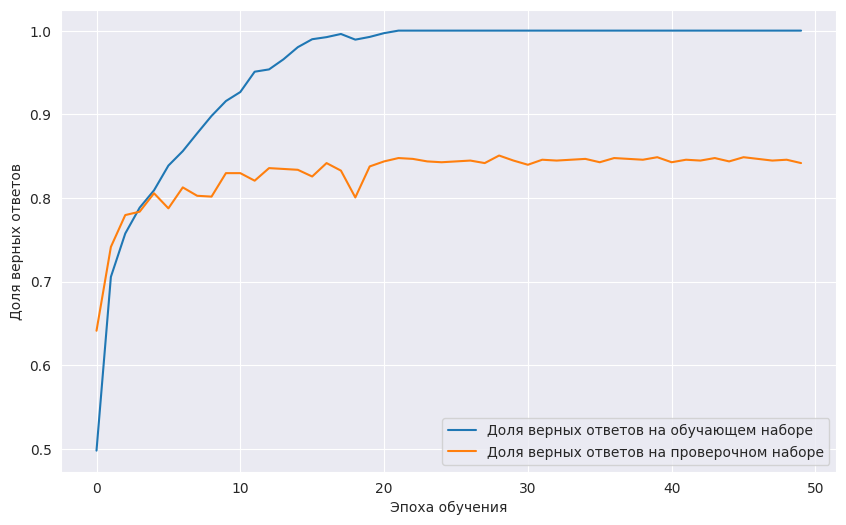

Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.851

Матрица ошибок для обучающей выборки:


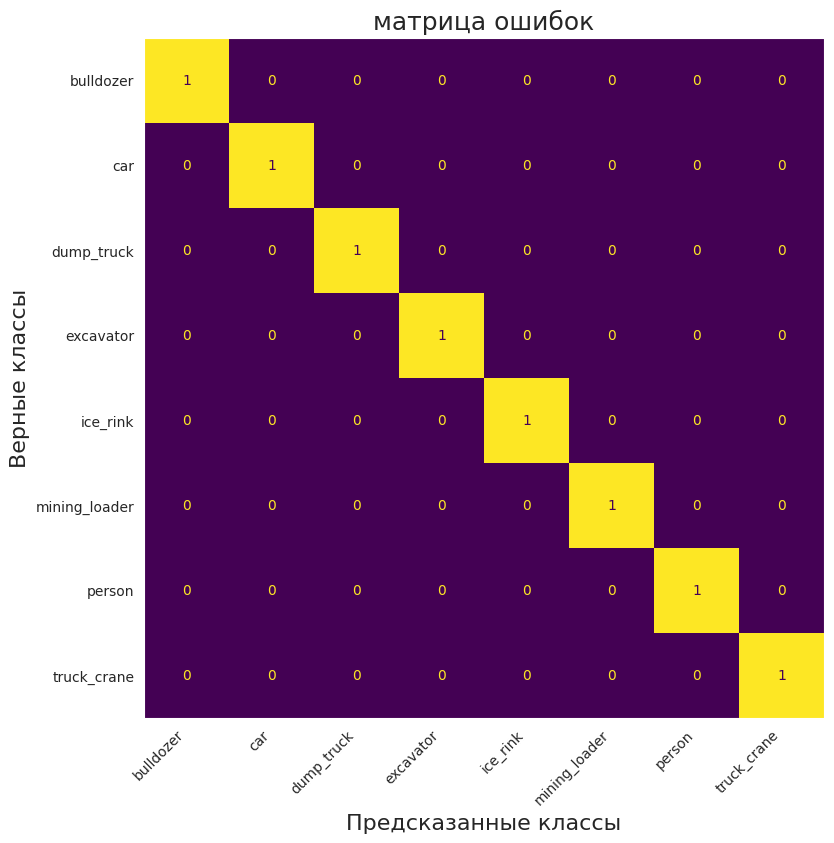


Матрица ошибок для проверочной выборки:


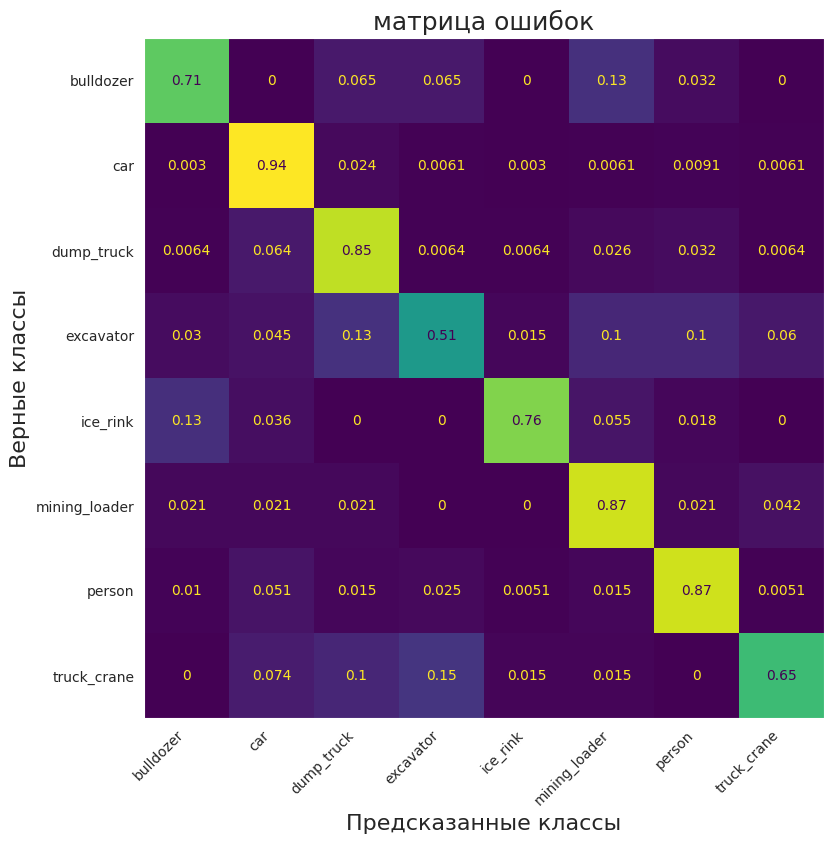

In [8]:
worker.show_learning_information(store_learning, model)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=5)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.822




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.996
Максимальная точность на проверочной выборке: 0.815




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.81




Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.992
Максимальная точность на проверочной выборке: 0.801




Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.994
Максимальная точность на проверочной выборке: 0.806




###############################################################################
 Финальные результаты
Средняя точность на обучающей выборке: 0.996
Максимальная точность на обучающей выборке: 1.0
Средняя точность на проверочной выборке: 0.81
Максимальная точность на проверочной выборке: 0.822


### Эксп. №2 (добавление еще одного блока Conv2D-MaxPool) (83.3%)

In [ ]:
# Создание выборок
img_size=(64, 64)
x_train, x_test, y_train, y_test = worker.create_sets(img_size)

Размер обучающей выборки: (3992, 64, 64, 3)
Размер проверочной выборки: (998, 64, 64, 3)


In [ ]:
def create_model():
  # Создание модели последовательной архитектуры
  model = Sequential()

  # Первый сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_size[0], img_size[1], 3)))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  # Второй сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  # Второй сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  # Блок классификации
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  # Компиляция модели
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=50,
                           verbose=1)

Epoch 1/50
160/160 [==============================] - 3s 8ms/step - loss: 1.7643 - accuracy: 0.3740 - val_loss: 1.4328 - val_accuracy: 0.5371
Epoch 2/50
160/160 [==============================] - 1s 6ms/step - loss: 1.2270 - accuracy: 0.5989 - val_loss: 1.1483 - val_accuracy: 0.6022
Epoch 3/50
160/160 [==============================] - 1s 6ms/step - loss: 0.9873 - accuracy: 0.6794 - val_loss: 0.9410 - val_accuracy: 0.7024
Epoch 4/50
160/160 [==============================] - 1s 6ms/step - loss: 0.8255 - accuracy: 0.7367 - val_loss: 0.7709 - val_accuracy: 0.7415
Epoch 5/50
160/160 [==============================] - 1s 6ms/step - loss: 0.7234 - accuracy: 0.7673 - val_loss: 0.7416 - val_accuracy: 0.7635
Epoch 6/50
160/160 [==============================] - 1s 6ms/step - loss: 0.6351 - accuracy: 0.7933 - val_loss: 0.7419 - val_accuracy: 0.7545
Epoch 7/50
160/160 [==============================] - 1s 6ms/step - loss: 0.5787 - accuracy: 0.8101 - val_loss: 0.7588 - val_accuracy: 0.7545
Epoch 

График обучения:


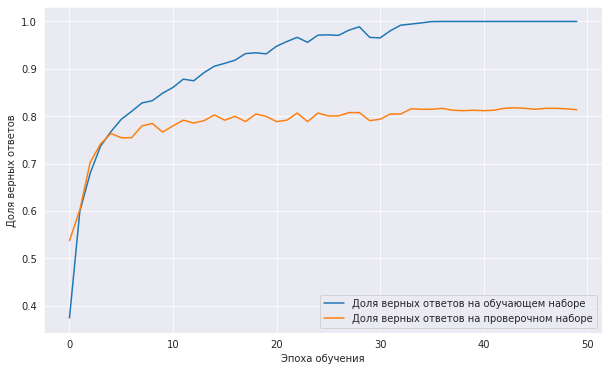

Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.818

Матрица ошибок для обучающей выборки:


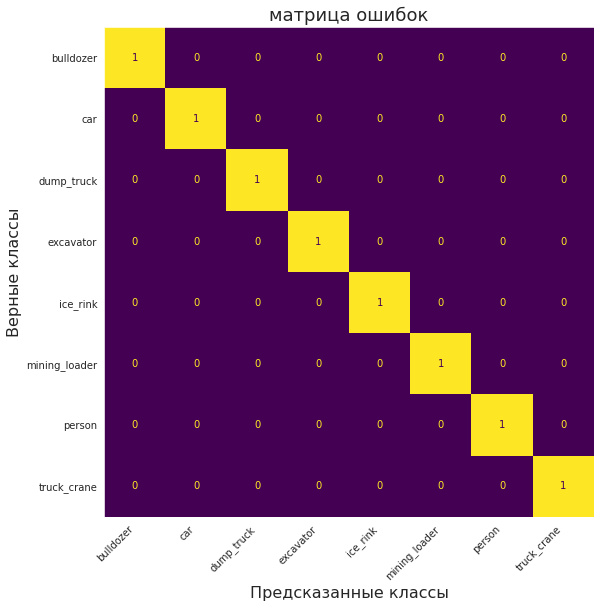


Матрица ошибок для проверочной выборки:


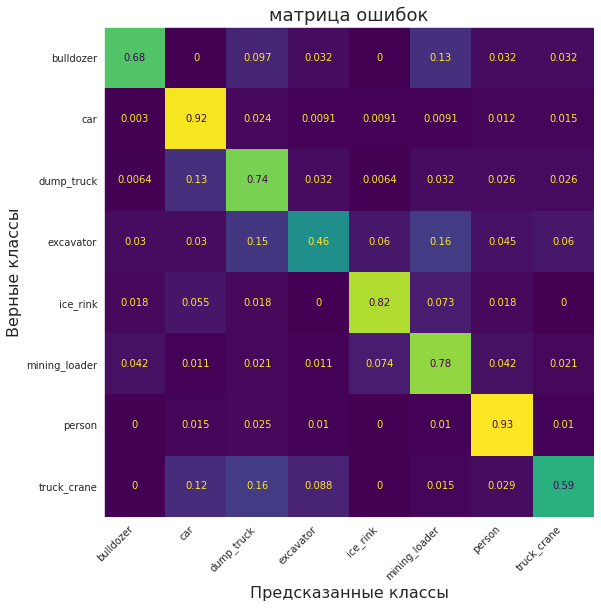

In [ ]:
worker.show_learning_information(store_learning, model)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=5)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.833




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.833




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.812




Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.828




Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.831




###############################################################################
 Финальные результаты
Средняя точность на обучающей выборке: 1.0
Максимальная точность на обучающей выборке: 1.0
Средняя точность на проверочной выборке: 0.827
Максимальная точность на проверочной выборке: 0.833


### Эксп. №3 (замена Flatten на GlobalMaxPooling) (83.7%)

In [ ]:
# Создание выборок
img_size=(64, 64)
x_train, x_test, y_train, y_test = worker.create_sets(img_size)

Размер обучающей выборки: (3992, 64, 64, 3)
Размер проверочной выборки: (998, 64, 64, 3)


In [ ]:
def create_model():
  # Создание модели последовательной архитектуры
  model = Sequential()

  # Первый сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_size[0], img_size[1], 3)))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  # Второй сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  # Второй сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  # Блок классификации
  model.add(GlobalMaxPooling2D())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  # Компиляция модели
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=50,
                           verbose=1)

Epoch 1/50
160/160 [==============================] - 3s 8ms/step - loss: 1.8633 - accuracy: 0.3322 - val_loss: 1.5762 - val_accuracy: 0.4319
Epoch 2/50
160/160 [==============================] - 1s 7ms/step - loss: 1.3840 - accuracy: 0.5243 - val_loss: 1.2035 - val_accuracy: 0.6052
Epoch 3/50
160/160 [==============================] - 1s 6ms/step - loss: 1.1704 - accuracy: 0.6087 - val_loss: 1.0369 - val_accuracy: 0.6433
Epoch 4/50
160/160 [==============================] - 1s 6ms/step - loss: 1.0212 - accuracy: 0.6603 - val_loss: 0.9242 - val_accuracy: 0.6874
Epoch 5/50
160/160 [==============================] - 1s 6ms/step - loss: 0.9045 - accuracy: 0.7007 - val_loss: 0.8577 - val_accuracy: 0.7104
Epoch 6/50
160/160 [==============================] - 1s 8ms/step - loss: 0.8174 - accuracy: 0.7340 - val_loss: 0.8103 - val_accuracy: 0.7425
Epoch 7/50
160/160 [==============================] - 1s 8ms/step - loss: 0.7393 - accuracy: 0.7570 - val_loss: 0.7617 - val_accuracy: 0.7365
Epoch 

График обучения:


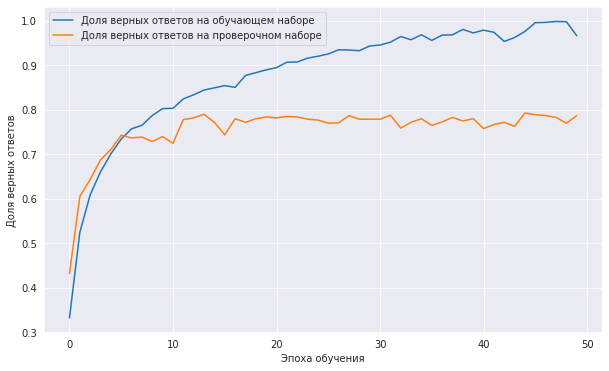

Максимальная точность на обучающей выборке: 0.998
Максимальная точность на проверочной выборке: 0.793

Матрица ошибок для обучающей выборки:


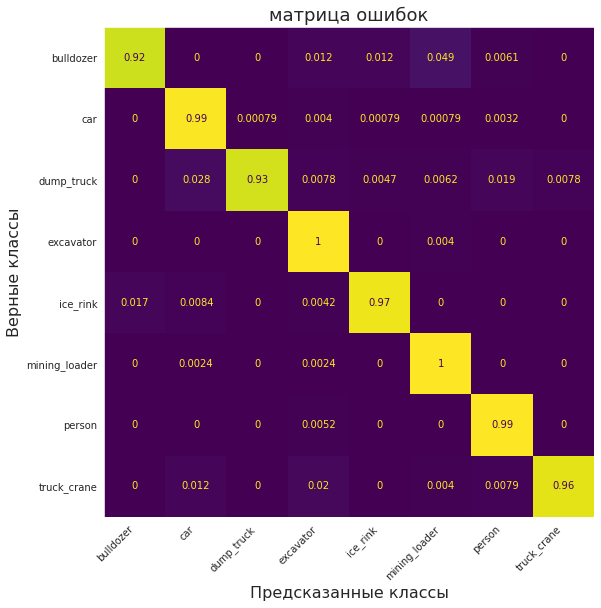


Матрица ошибок для проверочной выборки:


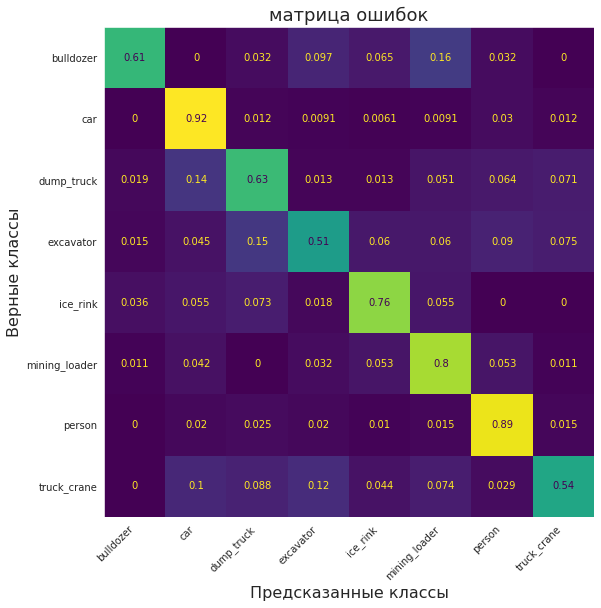

In [ ]:
worker.show_learning_information(store_learning, model)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=5)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.82




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.835




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.994
Максимальная точность на проверочной выборке: 0.805




Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.995
Максимальная точность на проверочной выборке: 0.807




Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.837




###############################################################################
 Финальные результаты
Средняя точность на обучающей выборке: 0.998
Максимальная точность на обучающей выборке: 1.0
Средняя точность на проверочной выборке: 0.82
Максимальная точность на проверочной выборке: 0.837


### Эксп. №4 (добавление Dense-слоя в конце) (83.9)

In [ ]:
# Создание выборок
img_size=(64, 64)
x_train, x_test, y_train, y_test = worker.create_sets(img_size)

Размер обучающей выборки: (3992, 64, 64, 3)
Размер проверочной выборки: (998, 64, 64, 3)


In [ ]:
def create_model():
  # Создание модели последовательной архитектуры
  model = Sequential()

  # Первый сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_size[0], img_size[1], 3)))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  # Второй сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  # Второй сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  # Блок классификации
  model.add(GlobalMaxPooling2D())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  # Компиляция модели
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
  return model

model = create_model()

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=50,
                           verbose=1)

Epoch 1/50
160/160 [==============================] - 4s 9ms/step - loss: 1.8290 - accuracy: 0.3414 - val_loss: 1.7571 - val_accuracy: 0.2956
Epoch 2/50
160/160 [==============================] - 1s 6ms/step - loss: 1.4215 - accuracy: 0.4990 - val_loss: 1.0989 - val_accuracy: 0.6152
Epoch 3/50
160/160 [==============================] - 1s 6ms/step - loss: 1.0668 - accuracy: 0.6428 - val_loss: 0.9375 - val_accuracy: 0.6864
Epoch 4/50
160/160 [==============================] - 1s 6ms/step - loss: 0.8909 - accuracy: 0.7057 - val_loss: 0.8255 - val_accuracy: 0.7184
Epoch 5/50
160/160 [==============================] - 1s 6ms/step - loss: 0.7678 - accuracy: 0.7430 - val_loss: 0.7760 - val_accuracy: 0.7335
Epoch 6/50
160/160 [==============================] - 1s 6ms/step - loss: 0.6836 - accuracy: 0.7710 - val_loss: 0.6824 - val_accuracy: 0.7505
Epoch 7/50
160/160 [==============================] - 1s 6ms/step - loss: 0.6180 - accuracy: 0.7968 - val_loss: 0.6857 - val_accuracy: 0.7475
Epoch 

График обучения:


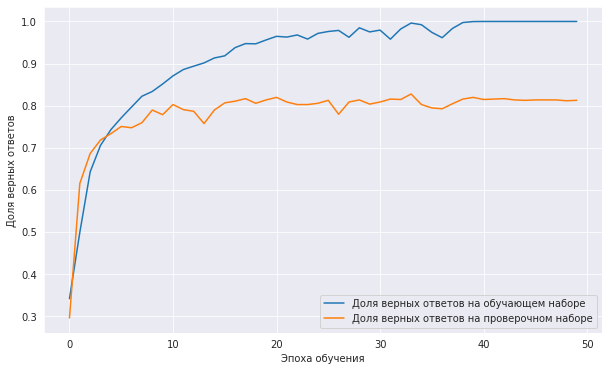

Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.828

Матрица ошибок для обучающей выборки:


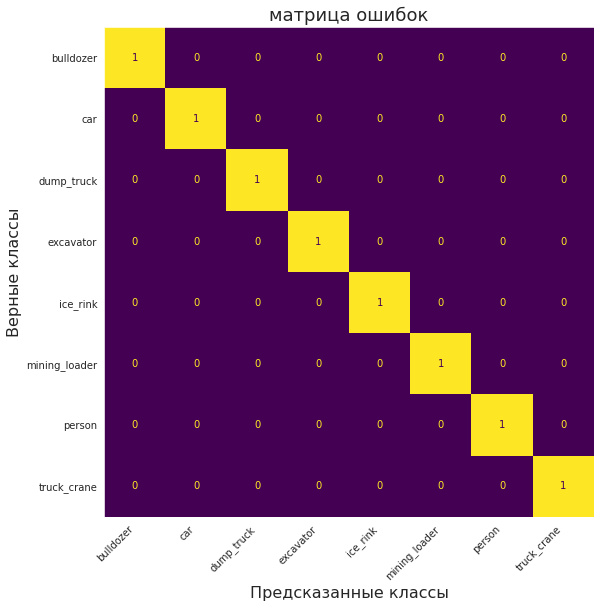


Матрица ошибок для проверочной выборки:


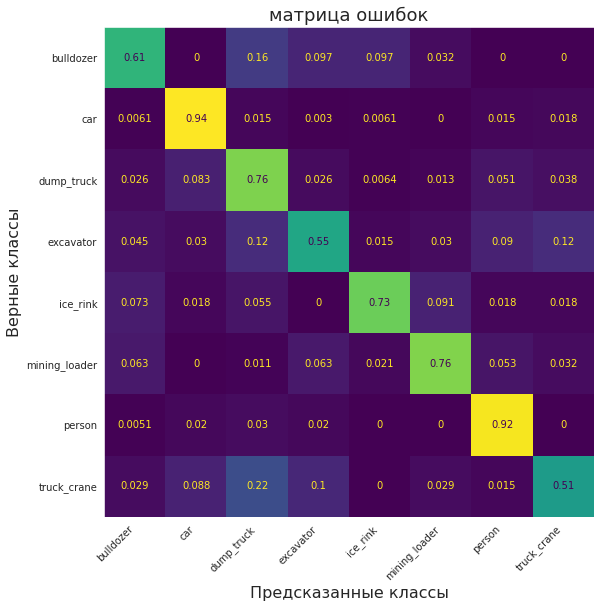

In [ ]:
worker.show_learning_information(store_learning, model)

**Несколько запусков**

In [ ]:
worker.train_model(
    funcModel=create_model,
    count=5)

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.839




Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.829




Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.836




Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.836




Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.825




###############################################################################
 Финальные результаты
Средняя точность на обучающей выборке: 1.0
Максимальная точность на обучающей выборке: 1.0
Средняя точность на проверочной выборке: 0.833
Максимальная точность на проверочной выборке: 0.839
